In [245]:
#importer libraries
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.linear_model import ElasticNet

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

In [263]:
# get file list
%run "add_features_to_data.py"

fp = Path("../cbk/")
bolig = fp/"fittest.csv"




In [264]:
# load data
bolig = pd.read_csv(bolig)


In [265]:
data, num_cols, cat_cols = add_features_to_data(bolig)


Unexpected exception formatting exception. Falling back to standard exception


C:\Users\cbk\Documents\isds2023\cbk\add_features_to_data.py:39: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_left'} in the result is deprecated and will raise a MergeError in a future version.
  df = df\
Traceback (most recent call last):
  File "c:\program files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\ProgramData\KB\Temp\ipykernel_3796\1750391046.py", line 1, in <cell line: 1>
    data, num_cols, cat_cols = add_features_to_data(bolig)
  File "C:\Users\cbk\Documents\isds2023\cbk\add_features_to_data.py", line 50, in add_features_to_data
    df['avg_sqm_price'] = pd.to_numeric(data['avg_sqm_price'], errors='coerce')
NameError: name 'data' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\program files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", lin

In [259]:
data = bolig\
    .merge(indk, on=["muni_code", "year"], how = 'left')\
    .merge(konth, on= ["muni_code", "year"], how= 'left')\
    .merge(gini, on = ["muni_code", "year"], how = 'left')\
    .merge(pop_dens, on = ["muni_code", "year"], how = 'left')\
    .sort_values(["year", "count"])\
    .dropna()\
    .assign(muni_code=lambda x: x['muni_code'].astype('category'))\
    .assign(year=lambda x: x['year'].astype('category'))

data['avg_sqm_price'] = pd.to_numeric(data['avg_sqm_price'], errors='coerce')

#drops very useless columns
cols_to_drop = [col for col in data.columns if col.startswith('Unnamed')]
data.drop(columns=cols_to_drop, inplace=True)
data.drop(columns="count", inplace =True)
data

C:\ProgramData\KB\Temp\ipykernel_3796\1752284869.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  data = bolig\


,muni_code,housing_type,year,avg_sqm_price,erhvervsindkomst,formueindkomst,anden_personlig_indkomst,kont_recip_tot,gini_index,pop_dens
35,161,Rækkehus,1994,6172.333333,126143.0,4615.0,1302.0,785.0,20.49,15.243609
2,161,Ejerlejlighed,1994,6174.088235,126143.0,4615.0,1302.0,785.0,20.49,15.243609
68,161,Villa,1994,5897.213793,126143.0,4615.0,1302.0,785.0,20.49,15.243609
36,161,Rækkehus,1995,6573.538462,131161.0,3697.0,1312.0,732.0,20.24,15.235338
69,161,Villa,1995,6250.870229,131161.0,3697.0,1312.0,732.0,20.24,15.235338
...,...,...,...,...,...,...,...,...,...,...
96,161,Villa,2020,26677.388158,255095.0,7453.0,2114.0,695.0,26.07,17.389474
30,161,Ejerlejlighed,2020,50572.333333,255095.0,7453.0,2114.0,695.0,26.07,17.389474
64,161,Rækkehus,2021,30582.785714,265696.0,10431.0,1917.0,615.0,26.55,17.578947
97,161,Villa,2021,29876.473684,265696.0,10431.0,1917.0,615.0,26.55,17.578947


In [225]:
# piller y og X ud:
y = data["avg_sqm_price"]
X = data.drop(columns = "avg_sqm_price")
X = X.drop(columns = "year") # piller som test år ud
X = X.drop(columns = "muni_code") # piller som test muni_code ud
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 35 to 31
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   housing_type              90 non-null     object 
 1   erhvervsindkomst          90 non-null     float64
 2   formueindkomst            90 non-null     float64
 3   anden_personlig_indkomst  90 non-null     float64
 4   kont_recip_tot            90 non-null     float64
 5   gini_index                90 non-null     float64
 6   pop_dens                  90 non-null     float64
dtypes: float64(6), object(1)
memory usage: 5.6+ KB


In [226]:

categorical_features = ['muni_code', 'housing_type', "year"]
categorical_features = ['housing_type'] # piller som test år og muni_code ud
numeric_features = ['erhvervsindkomst', 'formueindkomst', 'anden_personlig_indkomst', "kont_recip_tot", "gini_index", "pop_dens"]

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    (StandardScaler(), numeric_features),
    remainder='passthrough'
)

# pipe_lasso = make_pipeline(
#     preprocessor ,
#     StandardScaler(with_mean=False),
#     PolynomialFeatures(degree=3, include_bias=False),
#     Lasso(random_state=1) # komma fjernet
# )

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=(1 / 3), random_state=1)

lambdas = np.logspace(-4, 4, 12)

# YOUR CODE HERE
kfolds = KFold(n_splits=5)
folds = list(kfolds.split(X_dev, y_dev))
mseCV = []

for l in lambdas:
    mseCV_ = []
    for train_idx, val_idx in folds:
        pipe_lassoCV = make_pipeline(
            preprocessor,
            PolynomialFeatures(degree=3, include_bias=False),
            StandardScaler(with_mean=False),
            Lasso(alpha = l, random_state=1, max_iter  = 10000))
        X_train, y_train = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx]
        pipe_lassoCV.fit(X_train, y_train)
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))
    mseCV.append(mseCV_)

#Lamda for lowest mse:
lambdaCV = pd.DataFrame(mseCV, index=lambdas)
optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)
# optimal lambda, mse
optimal_lambda

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.219e+06, tolerance: 6.574e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.548e+06, tolerance: 6.893e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.070e+07, to

1873.817423    1.102505e+09
dtype: float64

Før vi pillede ting ud (år og sådan) 1873.817423    4.341138e+08
Efter vi pillede ting ud (år og sådan) 1873.817423    3.247531e+08
efter gini tilføjet: 1873.817423    3.299620e+08
 

<AxesSubplot:>

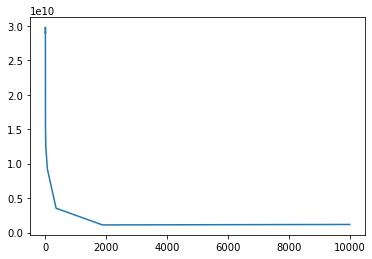

In [227]:
lambdaCV.mean(axis=1).plot()

In [230]:
l = optimal_lambda.index[0].item()

In [231]:
final_pipe_lasso = make_pipeline(
            preprocessor,
            PolynomialFeatures(degree=3, include_bias=False),
            StandardScaler(with_mean=False),
            Lasso(alpha = l, random_state=1, max_iter  = 10000)
)

model = final_pipe_lasso.fit(X_dev, y_dev)

In [232]:
y_hat  = model.predict(X_test)

In [211]:
pd.DataFrame({
    'y hat': y_hat,
    'Sand': y_test
})


,y hat,Sand
87,22596.942243,16532.975610
61,22470.323845,26223.388889
15,35473.208370,26354.601399
20,25221.381481,15872.842105
64,22966.543818,30582.785714
26,45824.628479,21597.254545
55,22375.647011,22553.256410
19,26998.082972,68931.012987
83,23503.172619,22353.659341
48,22383.418976,26239.055556


In [249]:
X_dev_transformed = preprocessor.fit_transform(X_dev)
poly_features = model.named_steps['polynomialfeatures']

poly_features.fit(X_dev_transformed)
transformed_feature_names = preprocessor.get_feature_names_out()  # Fra version 0.24 af scikit-learn.
polynomial_feature_names = poly_features.get_feature_names(input_features=transformed_feature_names)

polynomial_feature_names


lasso_coefs = model.named_steps['lasso'].coef_
feature_coefficients = dict(zip(polynomial_feature_names, lasso_coefs))

for feature, coef in feature_coefficients.items():
    if coef != 0:
        print(f"{feature}: {coef}")

# preprocessor.fit(X_dev)

len(lasso_coefs)

# feature_names = preprocessor.get_feature_names_out()
# poly_features.fit(X_dev_transformed)
# lasso_coefs = model.named_steps['lasso'].coef_
# feature_coefficients = dict(zip(feature_names, lasso_coefs))

# for feature, coef in feature_coefficients.items():
#     print(f"{feature}: {coef}")

num__erhvervsindkomst: 20678.386985383775
num__gini_index: 578.0891930970906
cat__housing_type_Rækkehus: 4368.3046327670845
num__erhvervsindkomst^2: 79.87967479725141
num__erhvervsindkomst num__gini_index: 6119.533851657731
num__erhvervsindkomst cat__housing_type_Rækkehus: 6859.294697358562
num__formueindkomst num__kont_recip_tot: 280.49739252824736
num__gini_index cat__housing_type_Rækkehus: -433.6631257921472
num__pop_dens^2: -1500.0488348881358
cat__housing_type_Ejerlejlighed cat__housing_type_Villa: -2365.394039205305
num__erhvervsindkomst^3: 217.50680886013689
num__erhvervsindkomst^2 num__gini_index: 0.09185289373902686
num__erhvervsindkomst^2 cat__housing_type_Rækkehus: 140.90951138294238
num__erhvervsindkomst num__pop_dens^2: -9370.048642692866
num__erhvervsindkomst num__pop_dens cat__housing_type_Villa: -65.61517831046852
num__erhvervsindkomst cat__housing_type_Ejerlejlighed cat__housing_type_Villa: -8436.699203414712
num__formueindkomst^2 num__kont_recip_tot: 78.18178663120702

c:\program files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


219

Nå. Det er altsammen meget godt. Hvordan med elasticnet?

In [234]:
from sklearn.compose import ColumnTransformer

# categorical_features = ['housing_type'] # piller som test år og muni_code ud
# numeric_features = ['erhvervsindkomst', 'formueindkomst', 'anden_personlig_indkomst', "kont_recip_tot", "gini_index" ]


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('polynomial', PolynomialFeatures(degree=3)),  # Tilføj denne linje
    ('classifier', ElasticNet())
])

param_grid = {
    'polynomial__degree': [1, 2, 3],  # Ny linje for at prøve forskellige polynomial grader
    'classifier__alpha': np.logspace(-4, 4, 12),
    'classifier__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

#[0.001, 0.01, 0.1, 1, 10, 100]
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
print(best_parameters)

best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.159e+09, tolerance: 1.306e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.721e+09, tolerance: 3.742e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e+07, tolerance: 4.206e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.159e+09, tolerance: 1.306e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.720e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e+07, tolerance: 4.208e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.084e+06, tolerance: 4.086e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e+07, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.760e+08, tolerance: 4.206e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.368e+06, tolerance: 1.306e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.961e+06, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.156e+09, tolerance: 1.306e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.713e+09, tolerance: 3.742e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.341e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e+08, tolerance: 4.208e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.468e+08, tolerance: 4.086e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.118e+09, tolerance: 4.086e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.256e+09, tolerance: 4.206e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.653e+07, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.200e+07, tolerance: 4.206e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.158e+09, tolerance: 1.306e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.714e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.100e+07, tolerance: 4.206e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.157e+09, tolerance: 1.306e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.713e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.587e+07, tolerance: 4.208e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.086e+07, tolerance: 4.086e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.873e+07, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.482e+08, tolerance: 3.742e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.372e+07, tolerance: 4.208e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e+08, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.341e+08, tolerance: 1.306e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.674e+09, tolerance: 3.742e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.525e+08, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.098e+08, tolerance: 1.306e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.412e+09, tolerance: 3.742e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.233e+08, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.680e+07, tolerance: 3.742e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.126e+07, tolerance: 4.208e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.568e+07, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.587e+09, tolerance: 3.742e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.207e+09, tolerance: 4.208e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.038e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.447e+08, tolerance: 4.086e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.030e+08, tolerance: 4.206e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.283e+09, tolerance: 4.208e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.377e+09, tolerance: 4.086e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.496e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e+08, tolerance: 1.306e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.439e+09, tolerance: 3.742e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.659e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.034e+08, tolerance: 1.306e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.346e+09, tolerance: 3.742e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.671e+08, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.205e+09, tolerance: 4.208e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.751e+08, tolerance: 4.086e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.594e+08, tolerance: 4.086e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.861e+07, tolerance: 4.206e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e+08, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.869e+09, tolerance: 4.206e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.374e+08, tolerance: 1.306e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.805e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.164e+08, tolerance: 1.306e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.743e+09, tolerance: 3.742e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.961e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.680e+09, tolerance: 3.742e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.057e+09, tolerance: 4.208e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.954e+08, tolerance: 1.306e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.303e+09, tolerance: 3.742e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.768e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.467e+08, tolerance: 4.086e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e+09, tolerance: 4.206e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.854e+07, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.017e+10, tolerance: 4.206e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.754e+07, tolerance: 1.306e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWa

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.897e+08, tolerance: 1.306e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.087e+09, tolerance: 3.742e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.812e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.882e+09, tolerance: 1.306e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e+10, tolerance: 3.742e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.034e+09, tolerance: 4.086e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.532e+07, tolerance: 1.306e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.194e+08, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.582e+10, tolerance: 3.742e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e+10, tolerance: 4.208e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e+10, tolerance: 4.086e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.036e+10, tolerance: 4.206e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.530e+09, tolerance: 1.306e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e+10, tolerance: 3.742e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

{'classifier__alpha': 1873.8174228603868, 'classifier__l1_ratio': 1, 'polynomial__degree': 1}


In [235]:
pd.DataFrame({"predicted":y_pred, "sand": y_test})

,predicted,sand
87,30218.593304,16532.975610
61,47551.291863,26223.388889
15,33662.683223,26354.601399
20,46600.086009,15872.842105
64,53955.565691,30582.785714
26,61271.092215,21597.254545
55,29987.676622,22553.256410
19,37076.032105,68931.012987
83,18519.012867,22353.659341
48,17997.611080,26239.055556


In [236]:
# LOAD FROM SCIKIT-LEARN
from sklearn.model_selection import learning_curve
pipe  = Pipeline([
    ('preprocessor', preprocessor),
    ('polynomial', PolynomialFeatures(degree=3)),  # Tilføj denne linje
    ('classifier', ElasticNet())
]) 



train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe,
                   X=X_dev,
                   y=y_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=10)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))

mse_.head(5)

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.005e+07, tolerance: 3.016e+05
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\program files\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\program files\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "c:\program files\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred =

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.934e+09, tolerance: 1.988e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.981e+09, tolerance: 2.023e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.263e+09, tolerance: 3.621e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.195e+09, tolerance: 3.664e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.228e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.179e+06, tolerance: 3.485e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.968e+06, tolerance: 3.507e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.687e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.666e+09, tolerance: 3.446e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e+09, tolerance: 3.561e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.199e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e+08, tolerance: 2.804e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e+09, tolerance: 2.851e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.464e+07, tolerance: 2.613e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e+08, tolerance: 2.804e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.666e+09, tolerance: 3.446e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.191e+09, tolerance: 3.613e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.664e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+09, tolerance: 3.019e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.666e+09, tolerance: 3.446e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.191e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e+08, tolerance: 2.804e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e+09, tolerance: 2.851e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e+08, tolerance: 2.804e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e+09, tolerance: 2.851e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+09, to

,Train,Test
sample size,,
2,6.528722e+03,NaN
5,1.294630e+06,3.470627e+10
8,4.181985e+06,1.978466e+10
10,5.978834e+06,1.597719e+10
13,2.338119e+07,5.877310e+09


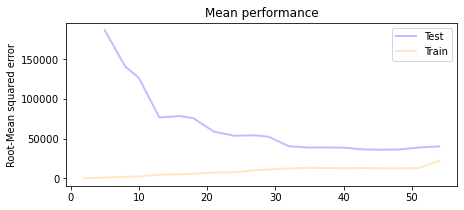

In [239]:
f_learn, ax = plt.subplots(figsize=(7,3))
ax.plot(train_sizes,np.sqrt(-test_scores.mean(1)), alpha=0.25, linewidth=2, label ='Test', color='blue') # negated, because we already use neg_MSE
ax.plot(train_sizes,np.sqrt(-train_scores.mean(1)), alpha=0.25, linewidth=2, label='Train', color='orange') # negated, because we already use neg_MSE

ax.set_title('Mean performance')
ax.set_ylabel('Root-Mean squared error')
ax.legend();

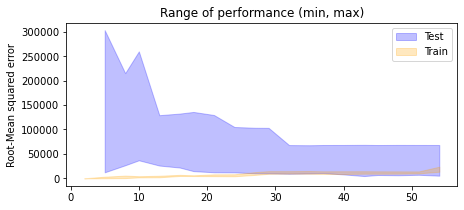

In [240]:
f_learn, ax = plt.subplots(figsize=(7,3))
ax.fill_between(train_sizes, np.sqrt(-test_scores.min(1)), np.sqrt(-test_scores.max(1)), alpha=0.25, label ='Test', color='blue')

ax.fill_between(train_sizes, np.sqrt(-train_scores.min(1)), np.sqrt(-train_scores.max(1)),  alpha=0.25, label='Train', color='orange')

ax.set_title('Range of performance (min, max)')
ax.set_ylabel('Root-Mean squared error')
ax.legend();